In [7]:
from astropy.io import fits
from astropy import wcs
import os
import numpy as np
from ants import cvMe, fitsPlay
from scipy.ndimage.interpolation import zoom

import  shutil

from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator
from matplotlib import transforms as mtransforms
from matplotlib.ticker import LogFormatter 
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

conv = cvMe.convert()
fp = fitsPlay.fitsplay()



home = '/home/'
#home = '/Users/'

rootDir = home+'maccagni/Projects/MFS/FornaxA/MUSE/'
cubeDir = rootDir+'cubes/'

GAL = 'FornaxE'
RUN = '_4750-6800-v100'

resDir= cubeDir+'results/'+GAL+RUN+'/'

inTable = resDir+GAL+'_table.fits'
#specTable = resDir+GAL+'_AllSpectra.fits'
starTable = resDir+GAL+'_ppxf-bestfit.fits'
specTable = resDir+GAL+'_VorSpectra.fits'

wavelenghtTable = resDir+GAL+'_VorSpectra_linear.fits'


resOut = resDir+'mycubes/'


if not os.path.exists(resOut):
    os.mkdir(resOut)


outCube = resOut+'Cube.fits'
outStar = resOut+'StarCube.fits'
outLines = resOut+'LineCube.fits'

outLinesRebin = resOut+'LineCubeRebin.fits'





print '''\t+---------+\n\t Inputs loaded\n\t+---------+''' 

	+---------+
	 Inputs loaded
	+---------+


In [8]:
#----------------------#
# From Fits Table to FITS Image - PPXF
#----------------------#

diffusion = 1e-5

tab = fits.open(inTable)

head = tab[0].header
headTab = tab[1].header
dataTab = tab[1].data

print dataTab['X']

#tabSpec = fits.open(specTable)
#headTabSpec = tabSpec[0].header
#headSpec = tabSpec[1].header

tabStar = fits.open(starTable)
tabStar.info()

headTabStar = tabStar[0].header

headStar = tabStar[1].header
dataStar = tabStar[1].data

tabSpec = fits.open(specTable)

tabSpec.info()

dataSpec = tabSpec[1].data
specExp = tabSpec[2].data
specExp = [item for t in specExp for item in t] 

tmp = np.array(dataSpec[23][0][:])
tmp = tmp.tolist()
newLines = tmp
tmp = np.array(dataStar[23][1][:])
tmp = tmp.tolist()
newStar = tmp


#dataWave = dataSpecStraight
print '''\t+---------+\n\t fits loaded\n\t+---------+'''     

[19.4 19.6 20.  ... 22.4 22.6 23.6]
Filename: /home/maccagni/Projects/MFS/FornaxA/MUSE/cubes/results/FornaxE_4750-6800-v100/FornaxE_ppxf-bestfit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BESTFIT       1 BinTableHDU     13   7645R x 2C   [J, 1666D]   
Filename: /home/maccagni/Projects/MFS/FornaxA/MUSE/cubes/results/FornaxE_4750-6800-v100/FornaxE_VorSpectra.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  VOR_SPECTRA    1 BinTableHDU     13   7645R x 2C   [1666D, 1666D]   
  2  LOGLAM        1 BinTableHDU     11   1666R x 1C   [D]   
	+---------+
	 fits loaded
	+---------+


In [9]:
#----------------------#
# rc param initialize
#----------------------#
params = {'figure.figsize'      : '10,10',
          'font.family'         :' serif',
          'font.serif'          :'times',
          'font.style'          : 'normal',
          'font.weight'         : 'book',
          'font.size'           : 24,
          'axes.linewidth'      : 2,
          'lines.linewidth'     : 3,
          'xtick.labelsize'     : 22,
          'ytick.labelsize'     : 22, 
          'xtick.direction'     :'in',
          'ytick.direction'     :'in',
          'xtick.major.size'    : 6,
          'xtick.major.width'   : 2,
          'xtick.minor.size'    : 3,
          'xtick.minor.width'   : 1,
          'ytick.major.size'    : 6,
          'ytick.major.width'   : 2,
          'ytick.minor.size'    : 3,
          'ytick.minor.width'   : 1, 
          'text.usetex'         : True,
          'text.latex.unicode'  : True
           }
plt.rcParams.update(params)

print '''\n\t+---------+\n\t Matplotlib initialized\n\t+---------+'''


	+---------+
	 Matplotlib initialized
	+---------+


/home/maccagni/programs/anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/maccagni/programs/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


63
5006.061747983248


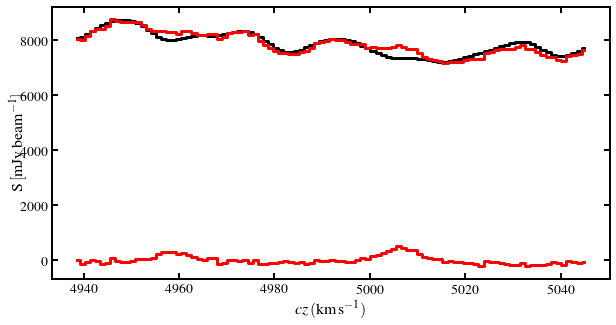

In [10]:
# Set plot specs

font_size = 16
plt.ioff()
plt.rc('xtick', labelsize=font_size-2)
plt.rc('ytick', labelsize=font_size-2)

fig, ax1 = plt.subplots(figsize=(10, 5))
#fig = plt.figure(figsize=(9, 6))
# fig.subplots_adjust(hspace=0.0)
#gs = gridspec.GridSpec(1, 1)

# Initialize subplots
#ax1 = fig.add_subplot(gs[0])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='both', bottom='on', top='on',
                left='on', right='on', which='major', direction='in')
ax1.tick_params(axis='both', bottom='on', top='on',
                left='on', right='on', which='minor', direction='in')

#flag_chans = cfg_par['spec_ex'].get('flag_chans', None)
#flag_chans1 = cfg_par['spec_ex'].get('flag_chans', None)





#if cfg_par['spec_ex'].get('zunit') == 'm/s':
x_data = np.exp(specExp)
#


ax1.set_xlabel(r'$cz\,(\mathrm{km}\,\mathrm{s}^{-1})$', fontsize=font_size)
y_data = np.array(newStar, dtype=float)
y_dataLines = np.array(newLines, dtype=float)

#y_sigma = np.array(spec_vec[spec_vec.colnames[2]])

#if cfg_par['spec_ex'].get('zunit') == 'MHz':
#    x_data /= 1e6
#    ax1.set_xlabel(r'Frequency [MHz]', fontsize=font_size)

ylabh = ax1.set_ylabel(
    r'S\,$[\mathrm{mJy}\,\mathrm{beam}^{-1}]$', fontsize=font_size)
ylabh.set_verticalalignment('center')

ax1.step(x_data[180:280], y_data[180:280], where='mid', color='black', linestyle='-')
ax1.step(x_data[180:280], y_dataLines[180:280], where='mid', color='red', linestyle='-')
ax1.step(x_data[180:280], y_dataLines[180:280]- y_data[180:280], where='mid', color='red', linestyle='-')

print np.argmax(y_dataLines[180:280]- y_data[180:280])

print x_data[180+63]

plt.show()

In [3]:
# these are arbitrary but must correspond, I choose the centre of the galaxy(usually offset with fov)
crPix3 =1

crPix1=200 # E 
crPix2=125

#crPix1 = 470 #A 
#crPix2 = 232


crVal1='03:22:41.734'
crVal2='-37:12:28.62'


crVal3 = np.min(specExp)

#only for Fornax E
#crVal3 = np.exp(dataSpecStraight[0])
#crVal3 =4750.2734375
crpix3 = 1

#deltaLambda = (np.max(dataWave)-np.min(dataWave))/len(dataWave)
#deltaLambda = 1.25
ra = conv.hms2deg(crVal1)
dec = conv.dms2deg(crVal2)

head['CRPIX1'] = crPix1
head['CRPIX2'] = crPix2

xMin = np.min(dataTab['X'])
xMax = np.max(dataTab['X'])

shapeX = (xMax-xMin)/head['PIXSIZE']

yMin = np.min(dataTab['Y'])
yMax = np.max(dataTab['Y'])

shapeY = (yMax-yMin)/head['PIXSIZE']

xAxis = (np.linspace(1, shapeX+1, shapeX+1) - head['CRPIX1']) *head['PIXSIZE']
yAxis = (np.linspace(1, shapeY+1, shapeY+1) - head['CRPIX2']) *head['PIXSIZE']

deltaLambda = (np.max(specExp)-np.min(specExp))/len(specExp)

data=np.empty([len(specExp),yAxis.shape[0],xAxis.shape[0]])
#data=np.empty([len(dataSpecStraight),yAxis.shape[0],xAxis.shape[0]])

Stars=np.empty([len(specExp),yAxis.shape[0],xAxis.shape[0]])
#Stars=np.empty([len(dataSpecStraight),yAxis.shape[0],xAxis.shape[0]])

Lines=np.empty([len(specExp),yAxis.shape[0],xAxis.shape[0]])
#Lines=np.empty([len(dataSpecStraight),yAxis.shape[0],xAxis.shape[0]])

w = wcs.WCS(naxis=3)

pixelSize = head['PIXSIZE']/3600.

# Set up an "Airy's zenithal" projection
# Vector properties may be set with Python lists, or Numpy arrays
w.wcs.crpix = [crPix1, crPix2, crPix3]
w.wcs.cdelt = np.array([-pixelSize,pixelSize,deltaLambda])
w.wcs.crval = [ra, dec, crVal3]
w.wcs.ctype = ["RA---TAN", "DEC--TAN","AWAV"]

header = w.to_header()

#w.wcs.set_pv([(2, 1, 45.0)])
header['EQUINOX'] = 2000
header['CRDER3'] = 0.026
header['CTYPE3'] = "AWAV"
header['CUNIT3'] = "Angstrom"

print header


hdu = fits.PrimaryHDU(data=data,header=header)

del header['LATPOLE']
del header['LONPOLE']

#create AllSpectra datacube
for i in xrange(0,dataTab['ID'].shape[0]):
    #print xAxis
    #print yAxis
    indexX = ((xAxis < (np.round(dataTab['X'][i],1)+diffusion)) & 
              ((np.round(dataTab['X'][i],1)-diffusion) < xAxis))
    indexY = ((yAxis < (np.round(dataTab['Y'][i],1)+diffusion)) & 
              ((np.round(dataTab['Y'][i],1)-diffusion) < yAxis))       

    xx = np.where(indexX)[0]
    yy = np.where(indexY)[0]

    indexBin =  dataTab['BIN_ID'][i]
    
    if indexBin>0 and xx and yy: 
               
        tmp = np.array(dataSpec[indexBin][0][:])
        tmp = tmp.tolist()
        #newTmp = zoom(tmp, factor, order=3)
        #newTmp = tmp
        data[:,yy[0],xx[0]] = tmp

        tmp = np.array(dataStar[indexBin][1][:])
        tmp = tmp.tolist()
        #newTmp = zoom(tmp, factor, order=3)
        #newTmp = tmp
        Stars[:,yy[0],xx[0]] = tmp
    
    else:
        pass

Lines = np.subtract(data,Stars)
        
fits.writeto(outCube,data,header,overwrite=True)
fits.writeto(outStar,Stars,header,overwrite=True)
#fits.writeto(outLines,Lines,header,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


WCSAXES =                    3 / Number of coordinate axes                      CRPIX1  =                200.0 / Pixel coordinate of reference point            CRPIX2  =                125.0 / Pixel coordinate of reference point            CRPIX3  =                  1.0 / Pixel coordinate of reference point            CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  CDELT3  =  0.00021505330686309 / [m] Coordinate increment at reference point    CUNIT1  = 'deg'                / Units of coordinate increment and value        CUNIT2  = 'deg'                / Units of coordinate increment and value        CUNIT3  = 'Angstrom'           / Units of coordinate increment and value        CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               CTYPE3  = 'AWAV    '           / Air wav

/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


	+---------+
	 fits saved
	+---------+


In [6]:
#----------------------#
# Cut around OIII line
#----------------------#

lambda_min = 4968
lambda_max = 5040

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()


oIII = resOut+'OIIICube.fits'

fp.zCubeCut(outLines,index_expMin,index_expMax,oIII)

ff = fits.open(oIII)

hh = ff[0].header
dd = ff[0].data


if 'LATPOLE' in hh:
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']
if "RADESYS" in hh:
    del hh['RADESYS']
if 'WCSAXES' in hh:
    del hh['WCSAXES']
if 'CUNIT3' in hh:
    del hh['CUNIT3']

hh['CDELT3'] = (lambda_max-lambda_min)/float(hh['NAXIS3'])
hh['CRVAL3'] = lambda_min
hh['CTYPE3'] = "AWAV"
hh['CUNIT3'] = "Angstrom"

fits.writeto(oIII,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

8.510846554812023
0.000215053306863
	+---------+
	 fits saved
	+---------+


In [7]:
#----------------------#
# Convert to VRAD
#----------------------#
C = 2.99792458e8
vsys = 1760

Orest = 5006.77e-10

oIII = resOut+'OIIICube.fits'''
oIIIVrad= resOut+'OIIICubeVrad.fits'

f = fits.open(oIII)
hh = f[0].header
dd = f[0].data

print hh['CRVAL3'], hh['CDELT3'], hh["NAXIS3"]
print hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3'])

vRadFin =(((hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3']))*1e-10-Orest) /Orest)*C/1e3+vsys

vRadIn = ((hh['CRVAL3']*1e-10-Orest)/Orest)*C/1e3+vsys
vDelRad = (vRadFin-vRadIn)/hh['NAXIS3']

hh['CRVAL3'] = vRadIn*1e3
hh['CDELT3'] = vDelRad*1e3
hh['CRPIX3'] = 1.0
if 'LATPOLE' in hh: 
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']

hh['CTYPE3'] = 'VRAD'
hh['CUNIT3'] = 'm/s'
    
print vRadIn, vDelRad
    
fits.writeto(oIIIVrad,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

4968 1.09090909091 66
5040.0
-561.447479445 65.3208191745
	+---------+
	 fits saved
	+---------+


In [8]:
#----------------------#
# Filter Cubes
#----------------------#

cube = resOut+'OIIICubeVrad.fits'
cubeSNR = resOut+'OIIICubeVradSNR.fits'
mom0Name = resOut+'OIII_mom0.fits'
mom1Name = resOut+'OIII_mom1.fits'

SNR= 3.
SNRVel= 5.

#measure noise along spaxel in empty region

lambda_min = 5020
lambda_max = 5539

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()

indexCubeA = 0
indexCubeB = 26
indexCubeC = 52
indexCubeD = 64

print index_expMin, index_expMax
lineCube = resOut+'LineCube.fits'
f = fits.open(lineCube)
lines = f[0].data

f = fits.open(cube)
dd = f[0].data
hh = f[0].header


newDD = dd.copy()*0.0
newDD = np.multiply(newDD,0.0)

mom0 = np.zeros([newDD.shape[1],newDD.shape[2]])
mom1 = np.zeros([newDD.shape[1],newDD.shape[2]])

vel = ((np.linspace(1, dd.shape[0], dd.shape[0]) - hh['CRPIX3']) * hh['CDELT3'] + hh['CRVAL3']) /1e3 

print vel[indexCubeB:indexCubeC]
#create AllSpectra datacube
for j in xrange(0,dd.shape[1]):
#for j in xrange(129,131):
    for i in xrange(0,dd.shape[2]):    
#    for i in xrange(112,113):
    
        noiseA = np.std(lines[indexCubeA:indexCubeB,j,i])
        noiseB = np.std(lines[indexCubeC:indexCubeD,j,i])
        noise = np.mean([noiseA,noiseB])
       
        maximum = np.max(dd[:,j,i])
        SNRLim = SNR*noise 
        SNRLimVel = SNRVel*noise 
                
        if maximum > SNRLim: 
            
            newDD[:,j,i] = dd[:,j,i]
            arr = dd[:,j,i]      
            arr[arr<=SNRLim] = 0.0
            mom0[j,i] = np.sum(arr[indexCubeB:indexCubeC])
            
        else:
            newDD[:,j,i] = np.nan

        if maximum > SNRLimVel:   
            arr = dd[:,j,i]
            arr[arr<=SNRLimVel] = 0.0
            
            #peak mom1
            mom1[j,i] = np.divide(np.sum(np.multiply(np.max(arr[indexCubeB:indexCubeC]),vel[np.argmax(arr[indexCubeB:indexCubeC])]))
                                  ,np.sum(arr[indexCubeB:indexCubeC]))
            #real mom1
            #mom1[j,i] = np.divide(np.sum(np.multiply(arr[indexCubeB:indexCubeC],vel[indexCubeB:indexCubeC]))
            #                      ,np.sum(arr[indexCubeB:indexCubeC]))
            
            
fits.writeto(cubeSNR,newDD,hh,overwrite=True)

if 'NAXIS3' in hh:
    del hh['NAXIS3']
if 'CRVAL3' in hh:
    hh['FREQ'] = hh['CRVAL3']
    del hh['CRVAL3']
if 'CDELT3' in hh:
    del hh['CDELT3']
if 'CRPIX3' in hh: 
    del hh['CRPIX3']
if 'CTYPE3' in hh:        
    del hh['CTYPE3']  
if 'CROTA3' in hh:
    del hh['CROTA3']
if 'CUNIT3' in hh:
    del hh['CUNIT3'] 
    
    
mom1[mom1==0.0] = np.nan    
mom0[mom0==0.0] = np.nan    

    
fits.writeto(mom0Name,mom0,hh,overwrite=True)
fits.writeto(mom1Name,mom1,hh,overwrite=True)


print '''\t+---------+\n\t fits saved\n\t+---------+'''     

256 713
[1136.89381909 1202.21463827 1267.53545744 1332.85627661 1398.17709579
 1463.49791496 1528.81873414 1594.13955331 1659.46037249 1724.78119166
 1790.10201084 1855.42283001 1920.74364919 1986.06446836 2051.38528753
 2116.70610671 2182.02692588 2247.34774506 2312.66856423 2377.98938341
 2443.31020258 2508.63102176 2573.95184093 2639.2726601  2704.59347928
 2769.91429845]


/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in divide


	+---------+
	 fits saved
	+---------+


In [101]:
#----------------------#
# Cut around OIII 2nd line
#----------------------#

lambda_min = 4930
lambda_max = 4990

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()


oIII = resOut+'OIII2Cube.fits'

fp.zCubeCut(outLines,index_expMin,index_expMax,oIII)

ff = fits.open(oIII)

hh = ff[0].header
dd = ff[0].data


if 'LATPOLE' in hh:
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']
if "RADESYS" in hh:
    del hh['RADESYS']
if 'WCSAXES' in hh:
    del hh['WCSAXES']
if 'CUNIT3' in hh:
    del hh['CUNIT3']

hh['CDELT3'] = (lambda_max-lambda_min)/float(hh['NAXIS3'])
hh['CRVAL3'] = lambda_min
header['CTYPE3'] = "AWAV"
header['CUNIT3'] = "Angstrom"

fits.writeto(oIII,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

8.503023481560486
0.000215044328423
	+---------+
	 fits saved
	+---------+


In [103]:
#----------------------#
# Convert to VRAD
#----------------------#
C = 2.99792458e8
vsys = 1760

Orest = 4958.83e-10

oIII = resOut+'OIII2Cube.fits'''
oIIIVrad= resOut+'OIII2CubeVrad.fits'

f = fits.open(oIII)
hh = f[0].header
dd = f[0].data

print hh['CRVAL3'], hh['CDELT3'], hh["NAXIS3"]
print hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3'])

vRadFin =(((hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3']))*1e-10-Orest) /Orest)*C/1e3+vsys

vRadIn = ((hh['CRVAL3']*1e-10-Orest)/Orest)*C/1e3+vsys
vDelRad = (vRadFin-vRadIn)/hh['NAXIS3']

hh['CRVAL3'] = vRadIn*1e3
hh['CDELT3'] = vDelRad*1e3
hh['CRPIX3'] = 1.0
if 'LATPOLE' in hh: 
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']

hh['CTYPE3'] = 'VRAD'
hh['CUNIT3'] = 'm/s'

    
print vRadIn, vDelRad
    
fits.writeto(oIIIVrad,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

4930 1.07142857143 56
4990.0
17.0451973267 64.7745950154
	+---------+
	 fits saved
	+---------+


In [12]:
#----------------------#
# Cut around Hb line
#----------------------#

lambda_min = 4850
lambda_max = 4874

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()


oIII = resOut+'HbetaCube.fits'

fp.zCubeCut(outLines,index_expMin,index_expMax,oIII)

ff = fits.open(oIII)

hh = ff[0].header
dd = ff[0].data


if 'LATPOLE' in hh:
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']
if "RADESYS" in hh:
    del hh['RADESYS']
if 'WCSAXES' in hh:
    del hh['WCSAXES']
if 'CUNIT3' in hh:
    del hh['CUNIT3']

hh['CDELT3'] = (lambda_max-lambda_min)/float(hh['NAXIS3'])
hh['CRVAL3'] = lambda_min
hh['CTYPE3'] = "AWAV"
hh['CUNIT3'] = "Angstrom"

fits.writeto(oIII,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

8.486760584443356
0.000215053306863
	+---------+
	 fits saved
	+---------+


In [20]:
#----------------------#
# Convert to VRAD
#----------------------#
C = 2.99792458e8
vsys = 1760

Orest = 4861.32e-10

oIII = resOut+'HbetaCube.fits'''
oIIIVrad= resOut+'HbetaCubeVrad.fits'

f = fits.open(oIII)
hh = f[0].header
dd = f[0].data

print hh['CRVAL3'], hh['CDELT3'], hh["NAXIS3"]
print hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3'])

vRadFin =(((hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3']))*1e-10-Orest) /Orest)*C/1e3+vsys

vRadIn = ((hh['CRVAL3']*1e-10-Orest)/Orest)*C/1e3+vsys
vDelRad = (vRadFin-vRadIn)/hh['NAXIS3']

hh['CRVAL3'] = vRadIn*1e3
hh['CDELT3'] = vDelRad*1e3
hh['CRPIX3'] = 1.0
if 'LATPOLE' in hh: 
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']

hh['CTYPE3'] = 'VRAD'
hh['CUNIT3'] = 'm/s'
    
print vRadIn, vDelRad
    
fits.writeto(oIIIVrad,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

4850 1.04347826087 23
4874.0
1061.90758383 64.3501996774
	+---------+
	 fits saved
	+---------+


In [22]:
#----------------------#
# Filter Cubes
#----------------------#

cube = resOut+'HbetaCubeVrad.fits'
cubeSNR = resOut+'HbetaCubeVradSNR.fits'
mom0Name = resOut+'Hbeta_mom0SNR-NoFit.fits'
mom1Name = resOut+'Hbeta_mom1SNR-NoFit.fits'

SNR= 3.
SNRVel= 5.

#measure noise along spaxel in empty region

lambda_min = 5020
lambda_max = 5539

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()

indexCubeA = 0
indexCubeB = 26
indexCubeC = 52
indexCubeD = 64
print index_expMin, index_expMax
lineCube = resOut+'LineCube.fits'
f = fits.open(lineCube)
lines = f[0].data

f = fits.open(cube)
dd = f[0].data
hh = f[0].header


newDD = dd.copy()*0.0
newDD = np.multiply(newDD,0.0)

mom0 = np.zeros([newDD.shape[1],newDD.shape[2]])
mom1 = np.zeros([newDD.shape[1],newDD.shape[2]])

vel = ((np.linspace(1, dd.shape[0], dd.shape[0]) - hh['CRPIX3']) * hh['CDELT3'] + hh['CRVAL3']) /1e3 

#create AllSpectra datacube
for j in xrange(0,dd.shape[1]):
#for j in xrange(129,131):
    for i in xrange(0,dd.shape[2]):    
#    for i in xrange(112,113):
    
        noiseA = np.std(lines[indexCubeA:indexCubeB,j,i])
        noiseB = np.std(lines[indexCubeC:indexCubeD,j,i])
        noise = np.mean([noiseA,noiseB])
       
        maximum = np.max(dd[:,j,i])
        SNRLim = SNR*noise 
        SNRLimVel = SNRVel*noise 
                
        if maximum > SNRLim: 
            
            newDD[:,j,i] = dd[:,j,i]
            arr = dd[:,j,i]      
            arr[arr<=SNRLim] = 0.0
            mom0[j,i] = np.sum(arr[indexCubeB:indexCubeC])
            
        else:
            newDD[:,j,i] = np.nan

        if maximum > SNRLimVel:   
            arr = dd[:,j,i]
            arr[arr<=SNRLimVel] = 0.0
            
            #peak mom1
           # mom1[j,i] = np.divide(np.sum(np.multiply(np.max(arr[indexCubeB:indexCubeC]),vel[np.argmax(arr[indexCubeB:indexCubeC])]))
            #                      ,np.sum(arr[indexCubeB:indexCubeC]))
            #real mom1
            #mom1[j,i] = np.divide(np.sum(np.multiply(arr[indexCubeB:indexCubeC],vel[indexCubeB:indexCubeC]))
            #                      ,np.sum(arr[indexCubeB:indexCubeC]))
            
            
fits.writeto(cubeSNR,newDD,hh,overwrite=True)

if 'NAXIS3' in hh:
    del hh['NAXIS3']
if 'CRVAL3' in hh:
    hh['FREQ'] = hh['CRVAL3']
    del hh['CRVAL3']
if 'CDELT3' in hh:
    del hh['CDELT3']
if 'CRPIX3' in hh: 
    del hh['CRPIX3']
if 'CTYPE3' in hh:        
    del hh['CTYPE3']  
if 'CROTA3' in hh:
    del hh['CROTA3']
if 'CUNIT3' in hh:
    del hh['CUNIT3'] 
    
    
mom1[mom1==0.0] = np.nan    
mom0[mom0==0.0] = np.nan    

    
fits.writeto(mom0Name,mom0,hh,overwrite=True)
fits.writeto(mom1Name,mom1,hh,overwrite=True)


print '''\t+---------+\n\t fits saved\n\t+---------+'''     

256 713
	+---------+
	 fits saved
	+---------+


In [106]:
#----------------------#
# Cut around NaD line
#----------------------#

lambda_min = 5810
lambda_max = 5950

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()


oIII = resOut+'NaDCube.fits'

fp.zCubeCut(outLines,index_expMin,index_expMax,oIII)

ff = fits.open(oIII)

hh = ff[0].header
dd = ff[0].data


if 'LATPOLE' in hh:
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']
if "RADESYS" in hh:
    del hh['RADESYS']
if 'WCSAXES' in hh:
    del hh['WCSAXES']
if 'CUNIT3' in hh:
    del hh['CUNIT3']

hh['CDELT3'] = (lambda_max-lambda_min)/float(hh['NAXIS3'])
hh['CRVAL3'] = lambda_min
header['CTYPE3'] = "AWAV"
header['CUNIT3'] = "Angstrom"

fits.writeto(oIII,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

8.667317348475787
0.000215044328423
	+---------+
	 fits saved
	+---------+


In [107]:
#----------------------#
# Convert to VRAD
#----------------------#
C = 2.99792458e8
vsys = 1760

Orest = 5893e-10

oIII = resOut+'NaDCube.fits'''
oIIIVrad= resOut+'NaDCubeVrad.fits'

f = fits.open(oIII)
hh = f[0].header
dd = f[0].data

print hh['CRVAL3'], hh['CDELT3'], hh["NAXIS3"]
print hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3'])

vRadFin =(((hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3']))*1e-10-Orest) /Orest)*C/1e3+vsys

vRadIn = ((hh['CRVAL3']*1e-10-Orest)/Orest)*C/1e3+vsys
vDelRad = (vRadFin-vRadIn)/hh['NAXIS3']

hh['CRVAL3'] = vRadIn*1e3
hh['CDELT3'] = vDelRad*1e3
hh['CRPIX3'] = 1.0
if 'LATPOLE' in hh: 
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']

hh['CTYPE3'] = 'VRAD'
hh['CUNIT3'] = 'm/s'
    
print vRadIn, vDelRad
    
fits.writeto(oIIIVrad,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

5810 1.27272727273 110
5950.0
-2462.42898592 64.7469943076
	+---------+
	 fits saved
	+---------+


In [180]:
#----------------------#
# Cut around OI line
#----------------------#

lambda_min = 6285
lambda_max = 6370

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()


oIII = resOut+'OICube.fits'

fp.zCubeCut(outLines,index_expMin,index_expMax,oIII)

ff = fits.open(oIII)

hh = ff[0].header
dd = ff[0].data


if 'LATPOLE' in hh:
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']
if "RADESYS" in hh:
    del hh['RADESYS']
if 'WCSAXES' in hh:
    del hh['WCSAXES']
if 'CUNIT3' in hh:
    del hh['CUNIT3']

hh['CDELT3'] = (lambda_max-lambda_min)/float(hh['NAXIS3'])
hh['CRVAL3'] = lambda_min
header['CTYPE3'] = "AWAV"
header['CUNIT3'] = "Angstrom"

fits.writeto(oIII,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

8.74589981921338
0.000215053306863
	+---------+
	 fits saved
	+---------+


In [181]:
#----------------------#
# Convert to VRAD
#----------------------#
C = 2.99792458e8
vsys = 1760

Orest = 6300.20e-10

oIII = resOut+'OICube.fits'''
oIIIVrad= resOut+'OICubeVrad.fits'

f = fits.open(oIII)
hh = f[0].header
dd = f[0].data

print hh['CRVAL3'], hh['CDELT3'], hh["NAXIS3"]
print hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3'])

vRadFin =(((hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3']))*1e-10-Orest) /Orest)*C/1e3+vsys

vRadIn = ((hh['CRVAL3']*1e-10-Orest)/Orest)*C/1e3+vsys
vDelRad = (vRadFin-vRadIn)/hh['NAXIS3']

hh['CRVAL3'] = vRadIn*1e3
hh['CDELT3'] = vDelRad*1e3
hh['CRPIX3'] = 1.0
if 'LATPOLE' in hh: 
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']

hh['CTYPE3'] = 'VRAD'
hh['CUNIT3'] = 'm/s'
    
print vRadIn, vDelRad
    
fits.writeto(oIIIVrad,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

6285 1.37096774194 62
6370.0
1036.7141739 65.2369431436
	+---------+
	 fits saved
	+---------+


In [120]:
#----------------------#
# Cut around NII  line
#----------------------#

lambda_min = 6480
lambda_max = 6660

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()


oIII = resOut+'NIICube.fits'''

fp.zCubeCut(outLines,index_expMin,index_expMax,oIII)

ff = fits.open(oIII)

hh = ff[0].header
dd = ff[0].data


if 'LATPOLE' in hh:
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']
if "RADESYS" in hh:
    del hh['RADESYS']
if 'WCSAXES' in hh:
    del hh['WCSAXES']
if 'CUNIT3' in hh:
    del hh['CUNIT3']

hh['CDELT3'] = (lambda_max-lambda_min)/float(hh['NAXIS3'])
hh['CRVAL3'] = lambda_min
header['CTYPE3'] = "AWAV"
header['CUNIT3'] = "Angstrom"

fits.writeto(oIII,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

8.776344822986335
0.000215044328423
	+---------+
	 fits saved
	+---------+


In [144]:
#----------------------#
# Convert to VRAD
#----------------------#
C = 2.99792458e8
vsys = 1760

Orest = 6583.34e-10

oIII = resOut+'NIICube.fits'
oIIIVrad= resOut+'NIICubeVrad.fits'

f = fits.open(oIII)
hh = f[0].header
dd = f[0].data

print hh['CRVAL3'], hh['CDELT3'], hh["NAXIS3"]
print hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3'])

vRadFin =(((hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3']))*1e-10-Orest) /Orest)*C/1e3+vsys

vRadIn = ((hh['CRVAL3']*1e-10-Orest)/Orest)*C/1e3+vsys
vDelRad = (vRadFin-vRadIn)/hh['NAXIS3']

hh['CRVAL3'] = vRadIn*1e3
hh['CDELT3'] = vDelRad*1e3
hh['CRPIX3'] = 1.0
if 'LATPOLE' in hh: 
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']

hh['CTYPE3'] = 'VRAD'
hh['CUNIT3'] = 'm/s'
    
print vRadIn, vDelRad
    
fits.writeto(oIIIVrad,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

6480 1.41732283465 127
6660.0
-2945.90196006 64.5421163692
	+---------+
	 fits saved
	+---------+


In [156]:
#----------------------#
# Filter Cubes
#----------------------#

cube = resOut+'NIICubeVrad.fits'
cubeSNR = resOut+'NIICubeVradSNR.fits'
mom0Name = resOut+'NII_mom0.fits'
mom1Name = resOut+'NII_mom1.fits'

SNR= 3.
SNRVel= 5.

#measure noise along spaxel in empty region

indexCubeA = 1120
indexCubeB1 = 1190

indexCubeB = 63
indexCubeC = 97

lineCube = resOut+'LineCube.fits'
f = fits.open(lineCube)
lines = f[0].data

f = fits.open(cube)
dd = f[0].data
hh = f[0].header


newDD = dd.copy()*0.0
newDD = np.multiply(newDD,0.0)

mom0 = np.zeros([newDD.shape[1],newDD.shape[2]])
mom1 = np.zeros([newDD.shape[1],newDD.shape[2]])

vel = ((np.linspace(1, dd.shape[0], dd.shape[0]) - hh['CRPIX3']) * hh['CDELT3'] + hh['CRVAL3']) /1e3 

print vel[indexCubeB:indexCubeC]
#create AllSpectra datacube
for j in xrange(0,dd.shape[1]):
#for j in xrange(129,131):
    for i in xrange(0,dd.shape[2]):    
#    for i in xrange(112,113):
    
        noise = np.std(lines[indexCubeA:indexCubeB1,j,i])
        #noiseB = np.std(lines[indexCubeC1:indexCubeD,j,i])
        #noise = np.mean([noiseA,noiseB])
       
        maximum = np.max(dd[indexCubeB:indexCubeC,j,i])
        SNRLim = SNR*noise 
        SNRLimVel = SNRVel*noise 
                
        if maximum > SNRLim: 

            arr = dd[indexCubeB:indexCubeC,j,i]      
            arr[arr<=SNRLim] = 0.0
            newDD[indexCubeB:indexCubeC,j,i] = arr
            mom0[j,i] = np.sum(arr)
            
        else:
            newDD[:,j,i] = np.nan

        if maximum > SNRLimVel:   
            arr = dd[indexCubeB:indexCubeC,j,i]
            arr[arr<=SNRLimVel] = 0.0
            
            #peak mom1
        #    mom1[j,i] = np.divide(np.sum(np.multiply(np.max(arr[indexCubeB:indexCubeC]),vel[np.argmax(arr[indexCubeB:indexCubeC])]))
        #                          ,np.sum(arr[indexCubeB:indexCubeC]))
            
            mom1[j,i] = np.divide(np.sum(np.multiply(arr,vel[indexCubeB:indexCubeC])),np.sum(arr))

            #real mom1
            #mom1[j,i] = np.divide(np.sum(np.multiply(arr[indexCubeB:indexCubeC],vel[indexCubeB:indexCubeC]))
            #                      ,np.sum(arr[indexCubeB:indexCubeC]))
            
hh['RESTFREQ'] = 4.553804877159618e14
hh['SPECSYS'] = 'BARYCENT'
hh['CRVAL3'] =  hh['CRVAL3'] - 1760e3

fits.writeto(cubeSNR,newDD,hh,overwrite=True)

if 'NAXIS3' in hh:
    del hh['NAXIS3']
if 'CRVAL3' in hh:
    del hh['CRVAL3']
if 'CDELT3' in hh:
    del hh['CDELT3']
if 'CRPIX3' in hh: 
    del hh['CRPIX3']
if 'CTYPE3' in hh:        
    del hh['CTYPE3']  
if 'CROTA3' in hh:
    del hh['CROTA3']
if 'CUNIT3' in hh:
    del hh['CUNIT3'] 
    
print np.sum(mom0)   

mom1[mom1==0.0] = np.nan    
mom0[mom0==0.0] = np.nan    

    
fits.writeto(mom0Name,mom0,hh,overwrite=True)
fits.writeto(mom1Name,mom1-1760,hh,overwrite=True)


print '''\t+---------+\n\t fits saved\n\t+---------+'''     

[1120.2513712  1184.79348757 1249.33560394 1313.87772031 1378.41983668
 1442.96195305 1507.50406942 1572.04618579 1636.58830216 1701.13041853
 1765.67253489 1830.21465126 1894.75676763 1959.298884   2023.84100037
 2088.38311674 2152.92523311 2217.46734948 2282.00946585 2346.55158222
 2411.09369859 2475.63581496 2540.17793132 2604.72004769 2669.26216406
 2733.80428043 2798.3463968  2862.88851317 2927.43062954 2991.97274591
 3056.51486228 3121.05697865 3185.59909502 3250.14121139]
4573967175.852328
	+---------+
	 fits saved
	+---------+


In [154]:
cubeSNR = resOut+'NIICubeVradSNR.fits'

cubeSNR_mir = resOut+'NIICubeVradSNR.mir'

mom0Mir = resOut+'NII_mom0.mir'
mom1Mir = resOut+'NII_mom1.mir'

mom0Fits = resOut+'NII_mom0Mir.fits'
mom1Fits = resOut+'NII_mom1Mir.fits'

if os.path.exists(cubeSNR_mir):
    shutil.rmtree(cubeSNR_mir)

if os.path.exists(mom0Mir):
    shutil.rmtree(mom0Mir)
    
if os.path.exists(mom1Mir):
    shutil.rmtree(mom1Mir)
 
    
if os.path.exists(mom0Fits):
    os.remove(mom0Fits)
    
if os.path.exists(mom1Fits):
    os.remove(mom1Fits)

pyfits = lib.miriad('fits')
pyfits.op = 'xyin'
pyfits.in_ = cubeSNR
pyfits.out = cubeSNR_mir
pyfits.go()

mom = lib.miriad('moment')
mom.in_ = cubeSNR_mir
mom.out = mom0Mir
mom.mom = '0'
mom.go()

mom.in_ = cubeSNR_mir
mom.out = mom1Mir
mom.mom = '1'
mom.go()

pyfits = lib.miriad('fits')
pyfits.op = 'xyout'
pyfits.in_ = mom0Mir
pyfits.out = mom0Fits
pyfits.go()

pyfits = lib.miriad('fits')
pyfits.op = 'xyout'
pyfits.in_ = mom1Mir
pyfits.out = mom1Fits
pyfits.go()

print '''\t+---------+\n\t miriad is done\n\t+---------+'''     

	+---------+
	 miriad is done
	+---------+


In [115]:
#----------------------#
# Cut around SII  line
#----------------------#

lambda_min = 6680
lambda_max = 6790

lambda_expMin = np.log(lambda_min)
lambda_expMax = np.log(lambda_max)

index_expMin = (np.abs(specExp - lambda_expMin)).argmin()
index_expMax = (np.abs(specExp - lambda_expMax)).argmin()


oIII = resOut+'SIICube.fits'

fp.zCubeCut(outLines,index_expMin,index_expMax,oIII)

ff = fits.open(oIII)

hh = ff[0].header
dd = ff[0].data


if 'LATPOLE' in hh:
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']
if "RADESYS" in hh:
    del hh['RADESYS']
if 'WCSAXES' in hh:
    del hh['WCSAXES']
if 'CUNIT3' in hh:
    del hh['CUNIT3']

hh['CDELT3'] = (lambda_max-lambda_min)/float(hh['NAXIS3'])
hh['CRVAL3'] = lambda_min
header['CTYPE3'] = "AWAV"
header['CUNIT3'] = "Angstrom"

fits.writeto(oIII,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

8.806666073294002
0.000215044328423
	+---------+
	 fits saved
	+---------+


In [116]:
#----------------------#
# Convert to VRAD
#----------------------#
C = 2.99792458e8
vsys = 1760

Orest = 6716.31e-10

oIII = resOut+'SIICube.fits'''
oIIIVrad= resOut+'SIICubeVrad.fits'

f = fits.open(oIII)
hh = f[0].header
dd = f[0].data

print hh['CRVAL3'], hh['CDELT3'], hh["NAXIS3"]
print hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3'])

vRadFin =(((hh['CRVAL3']+(hh['CDELT3']*hh['NAXIS3']))*1e-10-Orest) /Orest)*C/1e3+vsys

vRadIn = ((hh['CRVAL3']*1e-10-Orest)/Orest)*C/1e3+vsys
vDelRad = (vRadFin-vRadIn)/hh['NAXIS3']

hh['CRVAL3'] = vRadIn*1e3
hh['CDELT3'] = vDelRad*1e3
hh['CRPIX3'] = 1.0
if 'LATPOLE' in hh: 
    del hh['LATPOLE']
if 'LONPOLE' in hh:
    del hh['LONPOLE']

hh['CTYPE3'] = 'VRAD'
hh['CUNIT3'] = 'm/s'
    
print vRadIn, vDelRad
    
fits.writeto(oIIIVrad,dd,hh,overwrite=True)

print '''\t+---------+\n\t fits saved\n\t+---------+'''     

6680 1.44736842105 76
6790.0
139.249297608 64.6054361069
	+---------+
	 fits saved
	+---------+
